**Aufgabe 1**
*Berechnen Sie die erste und zweite Variation des Funktionals $E^{IE}$ (3).
Zeigen Sie, dass die erste Variation mit dem impliziten Euler-Verfahren übereinstimmt.*

*1. Variation (Gateuax Ableitung)*

Das Funktional ist gegeben durch:

$E^{IE}(u) = [ \int_{\Omega\} \epsilon\/2|| \,dx ]$

In [1]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# not used in code, might use later
def unitIntervallMesh(N=1, l0=2):
    m = NGMesh(dim=1)
 
    # Punkte für die Zerlegung auf dem Intervall [0,1]
    pnums = []
    for i in range(0, N+1):
        pnums.append (m.Add (MeshPoint (Pnt(i/N, 0, 0))))
 
    # Jedes 1D-Element (Teilintervall) kann einem Material zugeordnet
    # werden. In unserem Fall gibt es nur ein Material.
    idx = m.AddRegion("material", dim=1)
    for i in range(0,N):
        m.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))
 
    # Linkes und Rechtes Ende sind Randwertpunkte (0D-Elemente)
    idx_left = m.AddRegion("left", dim=0)
    idx_right = m.AddRegion("right", dim=0)
 
    m.Add (Element0D (pnums[0], index=idx_left))
    m.Add (Element0D (pnums[N], index=idx_right))
 
    # Damit haben wir das Mesh definiert
    mesh = Mesh(m)
    return mesh

In [3]:
ngmesh = NGMesh()
ngmesh.dim = 1

nel =1
l0=2

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add (MeshPoint (Pnt(i/nel*l0, 0, 0))))


for i in range(0,nel):
    ngmesh.Add (Element1D ([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D (pnums[0], index=1))
ngmesh.Add (Element0D (pnums[nel], index=2))

# Damit haben wir das Mesh definiert
mesh = Mesh(ngmesh)

In [4]:
# Geg:
eps = 1e-6
dt = 0.1
t0 = 0
tend = 2
t = t0

In [5]:
# FEM Raum => Annahme Order = 2
V = H1(mesh, order=2, dirichlet=[-1,0,1])  # TODO: check if Randwerte are correctly implemented like this

# Trial Funktion
u = V.TrialFunction()
# Test Funktion 
v = V.TestFunction()

gfu_n_minus_1 = GridFunction(V)  # TODO: check if gfu_n_minus_1 is appropriate way or if we just name it gfu

a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu_n_minus_1)**2)*dx)

In [6]:
a.AssembleLinearization(gfu_n_minus_1.vec)

u0 = CoefficientFunction([-1,0,1])  #TODO: set right Randbedingungen
gfu_n_minus_1.Set(u0,BND)

res = gfu_n_minus_1.vec.CreateVector()
du  = gfu_n_minus_1.vec.CreateVector()

In [7]:
# TODO: prove of concept, replace with implicit euler later

# FRAGEN: Ist das Aufgabe 2? Muss das Newtonverfahren für jeden Zeitschritt neu gelöst werden? mit Starbedingung aus dem vorherigen Schritt?

# Newton Verfahren:
for it in range(100):
    print("Newton iteration", it)

    # solve linearized problem:
    # F(u_n)
    a.Apply (gfu_n_minus_1.vec, res)

    # F'(u_n)
    a.AssembleLinearization(gfu_n_minus_1.vec)
    # TODO: Alternativ die selber berechnete variation (a1) verwenden mit:
    #a1.Assemble()

    du.data = a.mat.Inverse(V.FreeDofs()) * res
    # TODO: alternativ selber berechnete variation verwenden mit:
    #du.data = a1.mat.Inverse(V.FreeDofs()) * res

    # update interation
    # u_n+1 = u_n - du
    gfu_n_minus_1.vec.data -= du

    #stopping criteria
    stopcritval = sqrt(abs(InnerProduct(du,res)))
    print ("<A u",it,", A u",it,">_{-1}A0.S = ", stopcritval)
    if stopcritval < 1e-13:
        break


Newton iteration 0
<A u 0 , A u 0 >_{-1}A0.S =  0.06252259089626946
Newton iteration 1
<A u 1 , A u 1 >_{-1}A0.S =  0.054626310594272455
Newton iteration 2
<A u 2 , A u 2 >_{-1}A0.S =  0.04872287823138583
Newton iteration 3
<A u 3 , A u 3 >_{-1}A0.S =  0.045065212255938104
Newton iteration 4
<A u 4 , A u 4 >_{-1}A0.S =  0.04372754088482833
Newton iteration 5
<A u 5 , A u 5 >_{-1}A0.S =  0.04453175417892324
Newton iteration 6
<A u 6 , A u 6 >_{-1}A0.S =  0.047058592234605984
Newton iteration 7
<A u 7 , A u 7 >_{-1}A0.S =  0.05075803084593106
Newton iteration 8
<A u 8 , A u 8 >_{-1}A0.S =  0.05506051291299164
Newton iteration 9
<A u 9 , A u 9 >_{-1}A0.S =  0.059432779567076294
Newton iteration 10
<A u 10 , A u 10 >_{-1}A0.S =  0.06339963664611507
Newton iteration 11
<A u 11 , A u 11 >_{-1}A0.S =  0.06656358263114664
Newton iteration 12
<A u 12 , A u 12 >_{-1}A0.S =  0.06863096494340676
Newton iteration 13
<A u 13 , A u 13 >_{-1}A0.S =  0.06943559765613407
Newton iteration 14
<A u 14 , A 

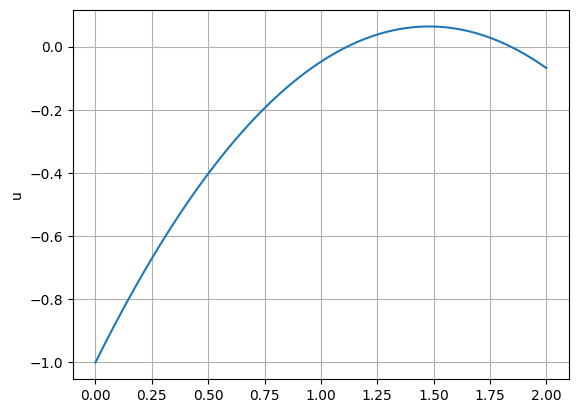

In [8]:
# TODO: check what exactly we are plotting here and why?
xi = np.linspace(0,l0,100)
ui = [gfu_n_minus_1(xip) for xip in xi]

plt.plot(xi,ui)
plt.grid()
plt.ylabel('u')
plt.show()

In [9]:
# own definition from NUM in FS23 for implicit euler. 
# TODO: check how to use this with the functional
def implizitEuler(xend, h, y0, f, df):
    x = [0.]
    y = [y0]

    # Verfahrensfunktion für implizit Euler
    def G(s, xk, yk):
        return s - yk - h * f(xk + h, s)

    # Partielle Ableitung nach s der Verfahrensfunktion
    def dG(s, xk, yk):
        return 1 - h * df(xk + h, s)

    def newton(s, xk, yk, tol=1e-12, maxIter=20):
        k = 0
        delta = 10 * tol
        while np.abs(delta) > tol and k < maxIter:
            delta = G(s, xk, yk) / dG(s, xk, yk)
            s -= delta
            k += 1
        return s

    while x[-1] < xend - h / 2:
        y.append(newton(y[-1], x[-1], y[-1], tol=1e-12, maxIter=20))
        x.append(x[-1] + h)

    return np.array(x), np.array(y)

In [10]:
def plot(gfu):
    xis = np.linspace(0,1,400)
    uis = np.array([gfu_n_minus_1(mesh(xi)) for xi in xis])
    plt.plot(xis,uis,label='FEM Lösung')

In [11]:
# TODO: check what this is. We think that this needs to be packed inside a while loop, but don't know the reason for it
"""
f = LinearForm(V)
f += CoefficientFunction(x*exp(-x**2))*v*dx

a.Assemble()
f.Assemble()


# Solve the variational problem
a.Assemble()
# nur wenn rechte Seite NICHT "festgemacht" ist!
# f = LinearForm(V)
f.Assemble()
inv = a.mat.Inverse(V.FreeDofs())

gfu = GridFunction(V)
gfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs())*f.vec
# print(f"this is vec.data: {gfu.vec.data}")

xis = np.linspace(0,1,400)
uis = np.array([gfu(mesh(xi)) for xi in xis])
plt.plot(xis,uis,label='FEM Lösung')
plt.show()

# Update the solution at the previous time step
gfu_n_minus_1.vec.data = gfu.vec

# Increment the time and continue the loop
t += dt
"""

'\nf = LinearForm(V)\nf += CoefficientFunction(x*exp(-x**2))*v*dx\n\na.Assemble()\nf.Assemble()\n\n\n# Solve the variational problem\na.Assemble()\n# nur wenn rechte Seite NICHT "festgemacht" ist!\n# f = LinearForm(V)\nf.Assemble()\ninv = a.mat.Inverse(V.FreeDofs())\n\ngfu = GridFunction(V)\ngfu.vec.data = a.mat.Inverse(freedofs=V.FreeDofs())*f.vec\n# print(f"this is vec.data: {gfu.vec.data}")\n\nxis = np.linspace(0,1,400)\nuis = np.array([gfu(mesh(xi)) for xi in xis])\nplt.plot(xis,uis,label=\'FEM Lösung\')\nplt.show()\n\n# Update the solution at the previous time step\ngfu_n_minus_1.vec.data = gfu.vec\n\n# Increment the time and continue the loop\nt += dt\n'